In [2]:
#help from Tovio
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import numpy as np
import folium
from folium import plugins
from plotly.offline import init_notebook_mode, iplot

In [3]:
crimedata = pd.read_csv('crime.csv', parse_dates = True)
values = pd.read_csv('propertyvalues.csv')

In [4]:
crimedata.shape

(479810, 19)

In [5]:
values.shape

(255, 4)

In [6]:
crimedata['REPORTED_DATE']=pd.to_datetime(crimedata.REPORTED_DATE)
crimedata['FIRST_OCCURRENCE_DATE']=pd.to_datetime(crimedata.FIRST_OCCURRENCE_DATE)
crimedata['LAST_OCCURRENCE_DATE']=pd.to_datetime(crimedata.LAST_OCCURRENCE_DATE)

temp=crimedata[['OFFENSE_ID','FIRST_OCCURRENCE_DATE','LAST_OCCURRENCE_DATE','REPORTED_DATE']]
temp.loc[:,'OCCURENCE_WINDOW']=temp.LAST_OCCURRENCE_DATE-temp.FIRST_OCCURRENCE_DATE
temp.loc[:,'OCCURENCE_WINDOW']=temp.OCCURENCE_WINDOW.fillna(0)
duds=temp[temp['OCCURENCE_WINDOW']<'0'].OFFENSE_ID
crimedata=crimedata[~crimedata['OFFENSE_ID'].isin(duds)]

temp=crimedata[['OFFENSE_ID','FIRST_OCCURRENCE_DATE','LAST_OCCURRENCE_DATE','REPORTED_DATE']]
temp.loc[:,'OCC_REPORT_GAP']=temp.REPORTED_DATE-temp.LAST_OCCURRENCE_DATE
temp.loc[:,'OCC_REPORT_GAP']=temp.OCC_REPORT_GAP.fillna(temp.REPORTED_DATE-temp.FIRST_OCCURRENCE_DATE)
duds2=temp[temp['OCC_REPORT_GAP']<'0'].OFFENSE_ID
crimedata=crimedata[~crimedata['OFFENSE_ID'].isin(duds2)]

temp=crimedata[['OFFENSE_ID','INCIDENT_ID','OFFENSE_CODE','OFFENSE_CODE_EXTENSION']]
temp.OFFENSE_ID=temp.OFFENSE_ID.astype(str)
temp.INCIDENT_ID=temp.INCIDENT_ID.astype(str)
temp.OFFENSE_CODE=temp.OFFENSE_CODE.map('{:04d}'.format).astype(str)
temp.OFFENSE_CODE_EXTENSION=temp.OFFENSE_CODE_EXTENSION.map('{:02d}'.format).astype(str)
temp['COMBINED_ID']=temp.INCIDENT_ID+temp.OFFENSE_CODE+temp.OFFENSE_CODE_EXTENSION
temp['ID_MATCH']=temp.COMBINED_ID==temp.OFFENSE_ID

crimedata=crimedata[crimedata['IS_CRIME']==1]
crimedata=crimedata[crimedata['REPORTED_DATE']<'2019']

crimedata['HOUR_REPORTED']=pd.DatetimeIndex(crimedata['REPORTED_DATE']).hour
crimedata['WEEKDAY_REPORTED']=pd.DatetimeIndex(crimedata['REPORTED_DATE']).weekday
crimedata['MONTH_REPORTED']=pd.DatetimeIndex(crimedata['REPORTED_DATE']).month
crimedata['YEAR_REPORTED']=pd.DatetimeIndex(crimedata['REPORTED_DATE']).year

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

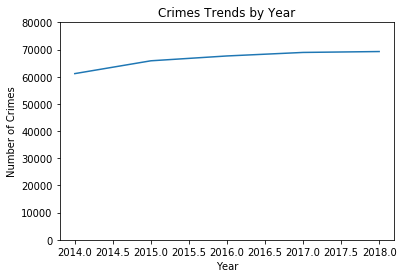

In [7]:
#Niel Orza's code for analysis
crimedata['YEAR_REPORTED'].groupby(crimedata.YEAR_REPORTED).agg('count').plot('line')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Crimes Trends by Year')
plt.ylim(bottom=0,top=80000)
plt.show()

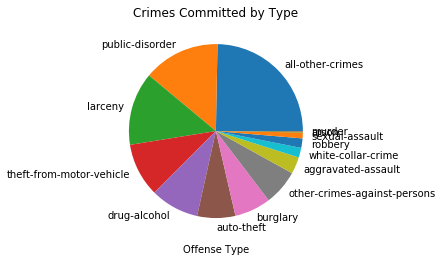

In [8]:
crimedata['OFFENSE_CATEGORY_ID'].value_counts().plot(kind='pie')
plt.title('Crimes Committed by Type')
plt.xlabel('Offense Type')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

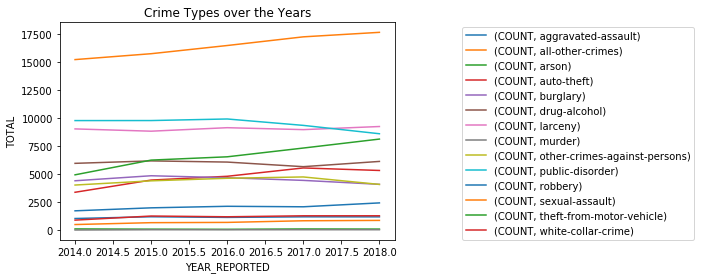

In [9]:
temp=crimedata[['YEAR_REPORTED','OFFENSE_CATEGORY_ID']].groupby([crimedata.YEAR_REPORTED, crimedata.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='YEAR_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
temp.plot(kind='line')
plt.legend(loc=(1.2,0))
plt.ylabel('TOTAL')
plt.title('Crime Types over the Years')
plt.show()

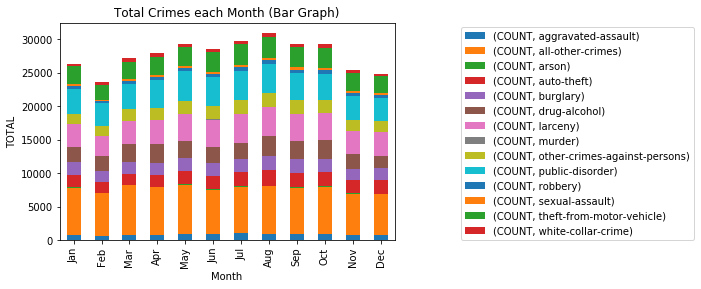

In [10]:
# bar graph of crimes by month, to see if crime is seasonal
temp=crimedata[['MONTH_REPORTED','OFFENSE_CATEGORY_ID']].groupby([crimedata.MONTH_REPORTED, crimedata.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='MONTH_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='bar',stacked=True)
plt.legend(loc=(1.2,0))
plt.title('Total Crimes each Month (Bar Graph)')
plt.xlabel('Month')
plt.ylabel('TOTAL')
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.show()

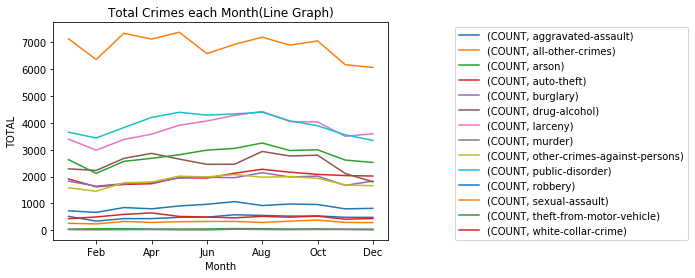

In [11]:
#line graph of crimes by month to see if certain crimes increase noticeably in certain months
temp=crimedata[['MONTH_REPORTED','OFFENSE_CATEGORY_ID']].groupby([crimedata.MONTH_REPORTED, crimedata.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='MONTH_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='line')
plt.legend(loc=(1.2,0))
plt.title('Total Crimes each Month(Line Graph)')
plt.xlabel('Month')
plt.ylabel('TOTAL')
ax.set_xticklabels(('','Feb','Apr','Jun','Aug','Oct','Dec'))

plt.show()

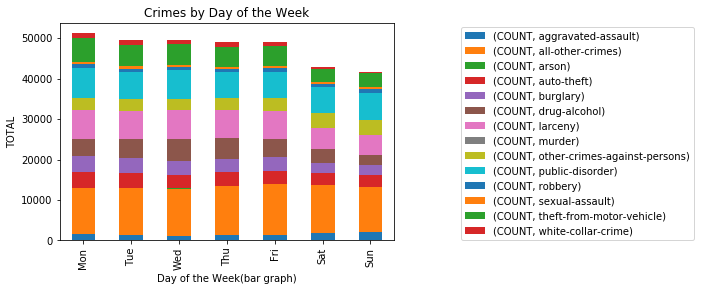

In [12]:
temp=crimedata[['WEEKDAY_REPORTED','OFFENSE_CATEGORY_ID']].groupby([crimedata.WEEKDAY_REPORTED, crimedata.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='WEEKDAY_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='bar',stacked=True)
plt.legend(loc=(1.2,0))
plt.xlabel('Day of the Week(bar graph)')
plt.ylabel('TOTAL')
plt.title('Crimes by Day of the Week')
ax.set_xticklabels(('Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.show()

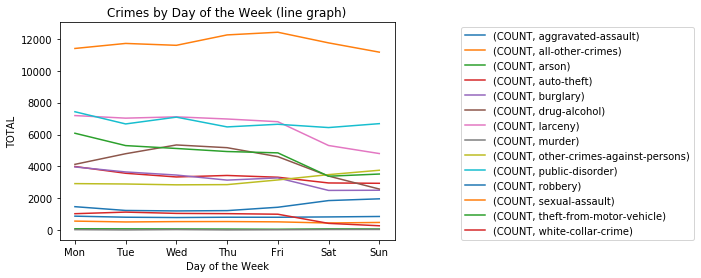

In [13]:
temp=crimedata[['WEEKDAY_REPORTED','OFFENSE_CATEGORY_ID']].groupby([crimedata.WEEKDAY_REPORTED, crimedata.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='WEEKDAY_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='line')
plt.legend(loc=(1.2,0))
plt.title('Crimes by Day of the Week (line graph)')
plt.xlabel('Day of the Week')
plt.ylabel('TOTAL')
ax.set_xticklabels(('','Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.show()

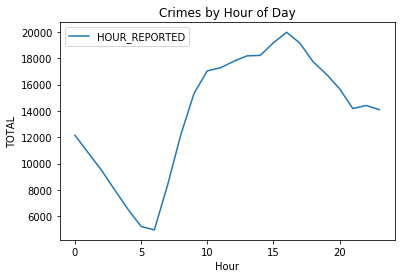

In [14]:
temp=crimedata[['HOUR_REPORTED']].groupby([crimedata.HOUR_REPORTED]).agg('count')
temp.plot(kind='line')
plt.xlabel('Hour')
plt.ylabel('TOTAL')
plt.title('Crimes by Hour of Day')
plt.show()

No handles with labels found to put in legend.


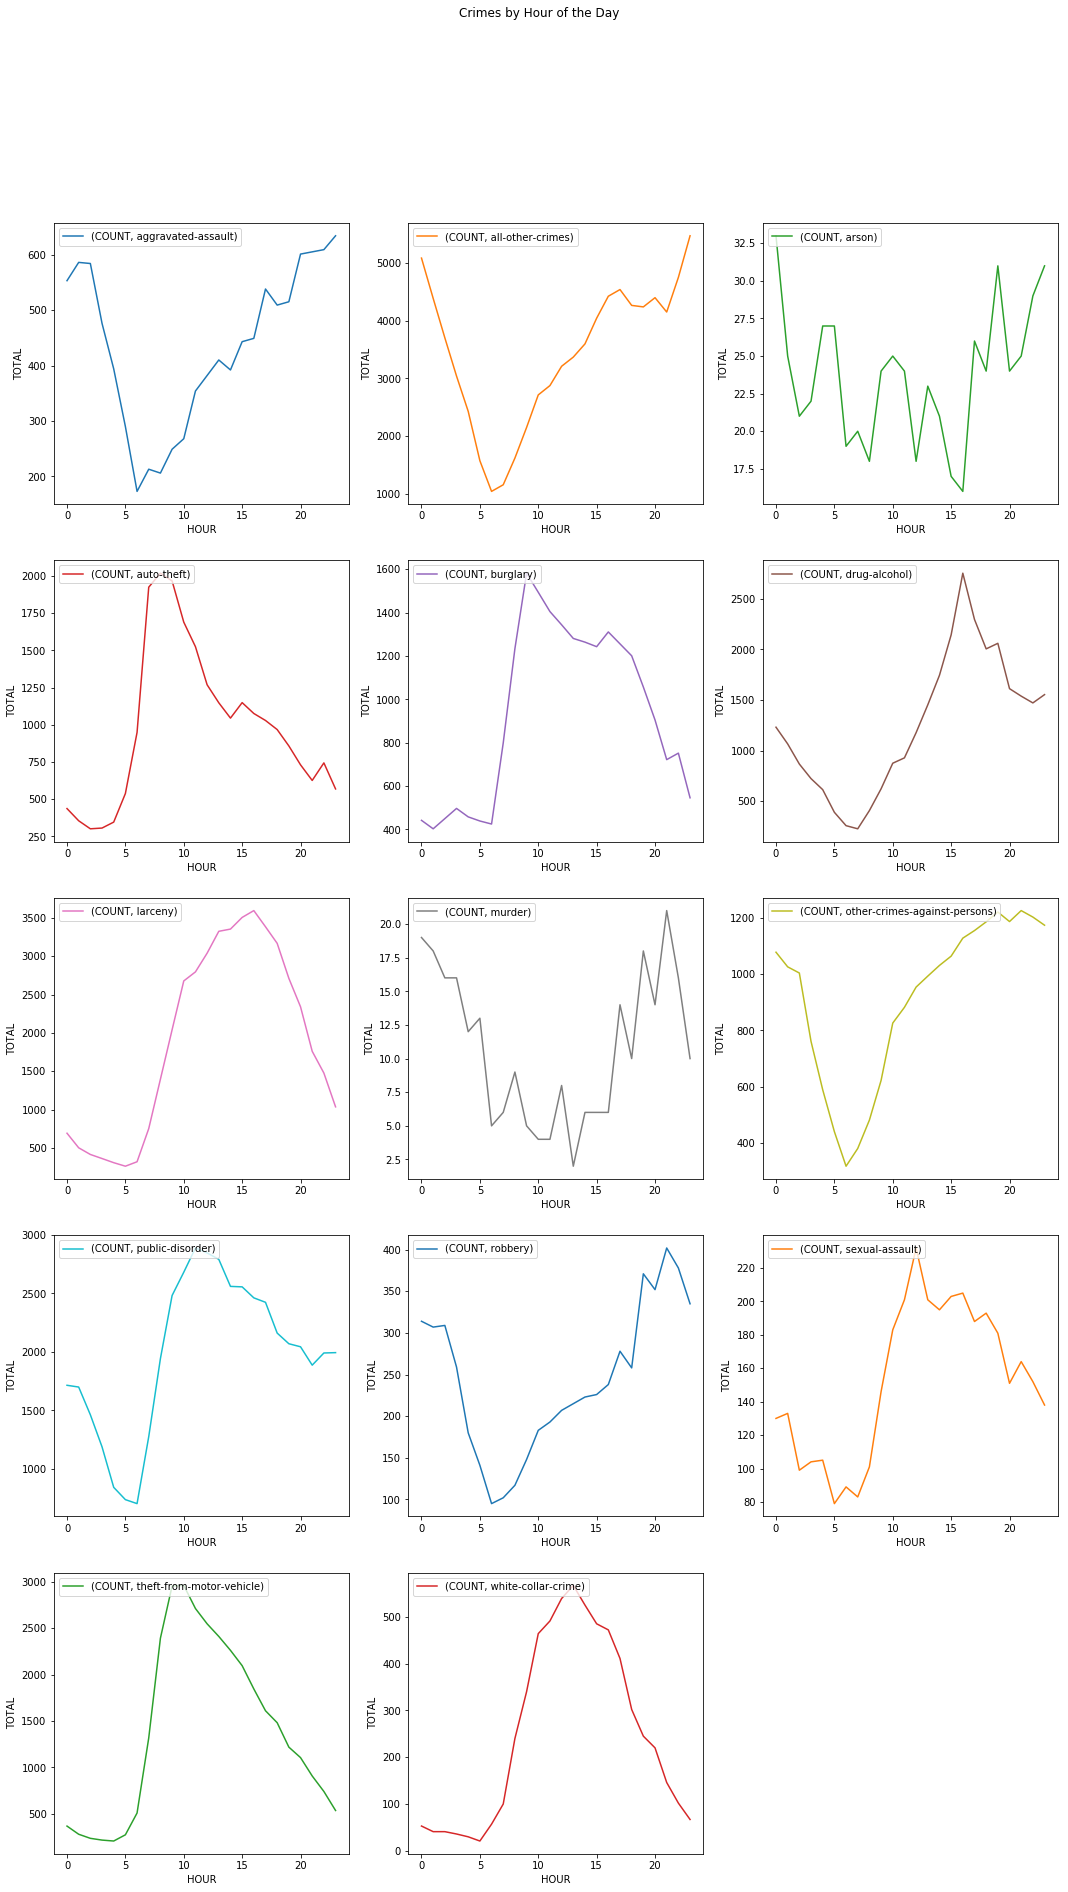

In [15]:
temp=crimedata[['HOUR_REPORTED','OFFENSE_CATEGORY_ID']].groupby([crimedata.HOUR_REPORTED, crimedata.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='HOUR_REPORTED',axis=1)
temp.columns=['COUNT']
temp.index=temp.index.rename('HOUR',level=0)

temp=temp.unstack(level=1)
fig=temp.plot(kind='line', figsize=(18,30),subplots=True,layout=(-1,3),sharex=False,sharey=False)
for row in fig:
    for item in row:
        item.set_ylabel('TOTAL')
        item.legend(loc='upper left')
plt.suptitle('Crimes by Hour of the Day')
plt.show()

In [16]:
def heatmap_creator(*args):
    #filter out all entries with no Lat/Lon data
    check_for_coordinates=crimedata['GEO_LAT'].isna()|crimedata['GEO_LON'].isna()
    temp=crimedata[~check_for_coordinates]
    #filter based on the provided parameters
    for item in args:
        a,b=item
        temp=temp[temp[a]==b]
        print(str(a)+': '+str(b))
    #Generate heatmap
    hm_prep=temp[['GEO_LAT','GEO_LON']].as_matrix()
    m = folium.Map(location=[39.73,-104.90], tiles='Stamen Toner',zoom_start=11, control_scale=True)
    m.add_children(plugins.HeatMap(hm_prep,radius=15))
    return display(m)

In [17]:
heatmap_creator(('OFFENSE_CATEGORY_ID','drug-alcohol'))

OFFENSE_CATEGORY_ID: drug-alcohol


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.



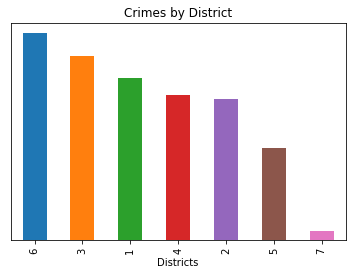

In [21]:
crimedata['DISTRICT_ID'].value_counts().plot(kind='bar')
plt.title('Crimes by District')
plt.xlabel('Districts')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

# year2018 = (crimedata.REPORTED_DATE >= '2018-01-01') & (crimedata.REPORTED_DATE < '2019-01-01')
# crimedata = crimedata[year2018]
# for i in range(1,len(crimedata.DISTRICT_ID.unique())+1):
#     data1 = crimedata[crimedata.DISTRICT_ID == i]
#     district1 = data1.OFFENSE_CATEGORY_ID.value_counts()
#     labels = district1.index
#     values = district1.values
#     trace = go.Pie(labels = labels, values = values)
#     name = 'District ' + str(i)
#     layout = go.Layout(title = name)
#     fig = go.Figure(data = [trace], layout = layout)
#     iplot(fig)